In [2]:
from bnt_smooth import ProcessMaps
from bnt_smooth import NzEuclid
import numpy as np
import pyccl as ccl 

In [3]:
z = np.linspace(0.01, 2.5, 500)
nside = 1500
l_max = 512
nslices = 15
nbins = 5
n_eff_list = [30.0 / nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
seed = 1234
alpha = 1.
beta = 1.



In [4]:
Nz = NzEuclid(nbins = nbins, z=z)
nz_list = Nz.get_nz()

In [5]:
sim = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim.set_cosmo()

0.0

# kernel plot

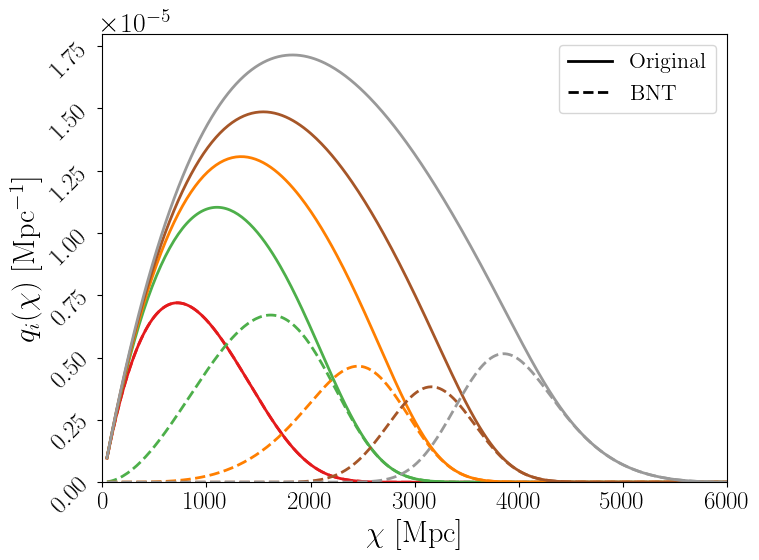

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

# --- Get chi and q(chi) for all source bins ---
chi, q_list = sim.get_lensing_kernels_on_z_grid()
q_bnt_list = sim.bnt_transform_lensing_kernels()

# --- Plot ---
plt.figure(figsize=(8, 6))

colors = plt.get_cmap('Set1')(np.linspace(0, 1, len(q_list)))

for i, (q, q_bnt) in enumerate(zip(q_list, q_bnt_list)):
    plt.plot(chi, q, linestyle='-', linewidth=2, color=colors[i])
    plt.plot(chi, q_bnt, linestyle='--', linewidth=2, color=colors[i])

# Custom legend entries (black solid and dashed lines only)
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Original'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='BNT')
]
plt.legend(handles=legend_elements, fontsize=16)

plt.xlabel(r'$\chi\ \mathrm{[Mpc]}$', fontsize=22)
plt.ylabel(r'$q_i(\chi)\ \mathrm{[Mpc^{-1}]}$', fontsize=22)
plt.xlim(0, 6000)
plt.ylim(bottom=0)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/kernels.pdf")
plt.show()

In [7]:
sim.get_bnt_matrix()

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.27009163, -1.27009163,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.65785846, -1.65785846,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.9734639 , -1.9734639 ,  1.        ]])

In [8]:
sim_strong_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=10.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_strong_baryon.set_cosmo()


sim_no_baryon = ProcessMaps(
    z_array=z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=0.,
    alpha=alpha,
    beta=beta,
    seed=np.random.randint(1e6),
    l_max=l_max,
    nside=nside,
    nslices=nslices
)
sim_no_baryon.set_cosmo()

0.0

# baryon plot

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_13237/2519610802.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues_r')


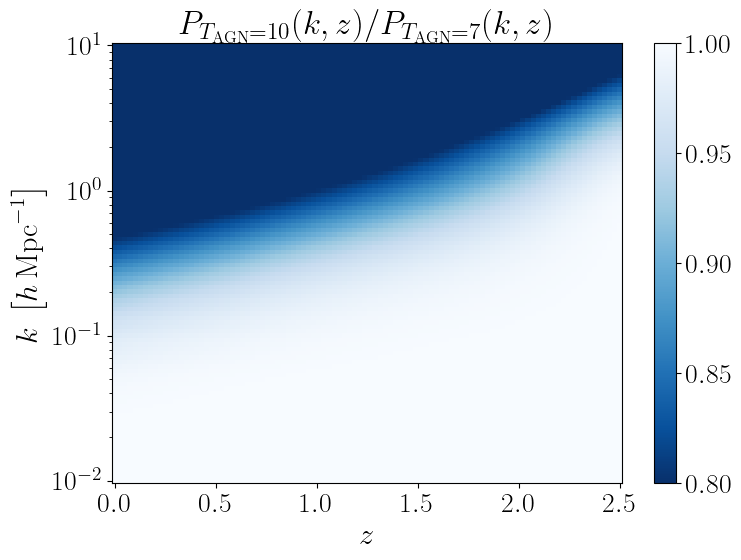

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Define k and z ranges
k = np.logspace(np.log10(0.01), np.log10(10.0), 100)
z = np.linspace(0, 2.5, 100)
a = 1.0 / (1.0 + z)

# Compute power spectra
p_strong = np.array([[ccl.nonlin_matter_power(sim_strong_baryon.cosmo, k=ki, a=ai) for ai in a] for ki in k])
p_weak = np.array([[ccl.nonlin_matter_power(sim.cosmo, k=ki, a=ai) for ai in a] for ki in k])

# Compute ratio
ratio = p_strong / p_weak

# Define normalization centered at 1
norm = Normalize(vmin=0.8, vmax=1.0)

# Use a reversed blue colormap (light to dark)
cmap = cm.get_cmap('Blues_r')

# Plot
plt.figure(figsize=(8, 6))
im = plt.pcolormesh(z, k, ratio, shading='auto', cmap=cmap, norm=norm)
plt.yscale('log')
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$k\;\left[h\,\mathrm{Mpc}^{-1}\right]$', fontsize=22)
plt.title('$P_{T_\mathrm{AGN} = 10} (k,z) / P_{T_\mathrm{AGN} = 7} (k,z) $')
plt.colorbar(im)
plt.tight_layout()
plt.savefig("plots/baryons.png")
plt.show()

# Fisher plot

Removed no burn in
Removed no burn in


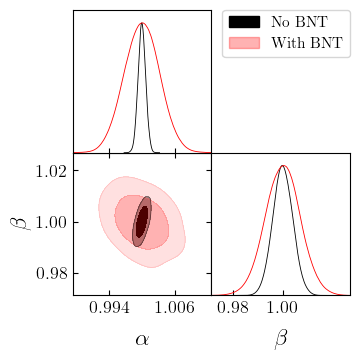

In [78]:
import numpy as np
from getdist import MCSamples, plots

# --- Load Fisher matrices ---
fisher_bnt = np.load("results/fisher_b7_bnt.npy")
fisher_nobnt = np.load("results/fisher_b7.npy")

# --- Fiducial point ---
theta_fid = np.array([1.0, 1.0])
cov_bnt = np.linalg.inv(fisher_bnt)
cov_nobnt = np.linalg.inv(fisher_nobnt)

# --- Draw samples ---
samples_bnt = np.random.multivariate_normal(theta_fid, cov_bnt, size=10_000)
samples_nobnt = np.random.multivariate_normal(theta_fid, cov_nobnt, size=10_000)

# --- Prepare GetDist samples ---
names = ["alpha", "beta"]
labels = [r"\alpha", r"\beta"]
g_nobnt = MCSamples(samples=samples_nobnt, names=names, labels=labels, label="No BNT")
g_bnt = MCSamples(samples=samples_bnt, names=names, labels=labels, label="With BNT")


# --- Plot ---
# --- Plot with custom settings ---
gplt = plots.get_subplot_plotter()
gplt.settings.axes_fontsize = 16        # Axis tick labels
gplt.settings.lab_fontsize = 20         # Axis labels
gplt.settings.legend_fontsize = 14
gplt.settings.alpha_filled_add = 0.3    # Increase transparency (lower value = more transparent)

gplt.triangle_plot(
    [g_nobnt, g_bnt],
    filled=True,
    contour_colors=["black", "red"]
)
gplt.export("plots/fisher_alpha_beta_comparison.pdf")

# Field plots

# Field Plots

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import ProcessMaps, NzEuclid

# --- Config ---
nside = 512
l_max = 1500
nslices = 5
nbins = 5
z = np.linspace(0.01, 2.5, 500)
Nz = NzEuclid(nbins=nbins, z=z)
nz_list = Nz.get_nz()
n_eff_list = [30. / nbins] * nbins
sigma_eps_list = [0.26] * nbins
baryon_feedback = 7.
seed = 42


# --- Parameter grid ---
param_grid = {
    "fiducial": (1.0, 1.0),
    "alpha15": (1.5, 1.0),
    "beta15": (1.0, 1.5)
}

# --- Store results ---
delta_maps_all = {}
kappa_maps_all = {}

for label, (alpha, beta) in param_grid.items():
    print(f"Simulating for {label} → (α, β) = ({alpha}, {beta})")
    sim = ProcessMaps(
        z_array=z,
        nz_list=nz_list,
        n_eff_list=n_eff_list,
        sigma_eps_list=sigma_eps_list,
        baryon_feedback=baryon_feedback,
        alpha=alpha,
        beta=beta,
        seed=seed,
        l_max=l_max,
        nside=nside,
        nslices=nslices
    )

    sim.set_cosmo()

    matter_fields = sim.generate_gauss_matter_fields_from_scratch()
    delta_maps = sim.make_skewed_delta_maps(matter_fields)
    kappa_maps = sim.compute_kappa_maps(delta_maps)

    delta_maps_all[label] = delta_maps
    kappa_maps_all[label] = kappa_maps

Simulating for fiducial → (α, β) = (1.0, 1.0)
Simulating for alpha15 → (α, β) = (1.5, 1.0)
Simulating for beta15 → (α, β) = (1.0, 1.5)


In [48]:
def sci_notation(val):
    """Format float in LaTeX 10^ notation."""
    if val == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(val))))
    base = val / 10**exponent
    return fr"{base:.1f} \times 10^{{{exponent}}}"


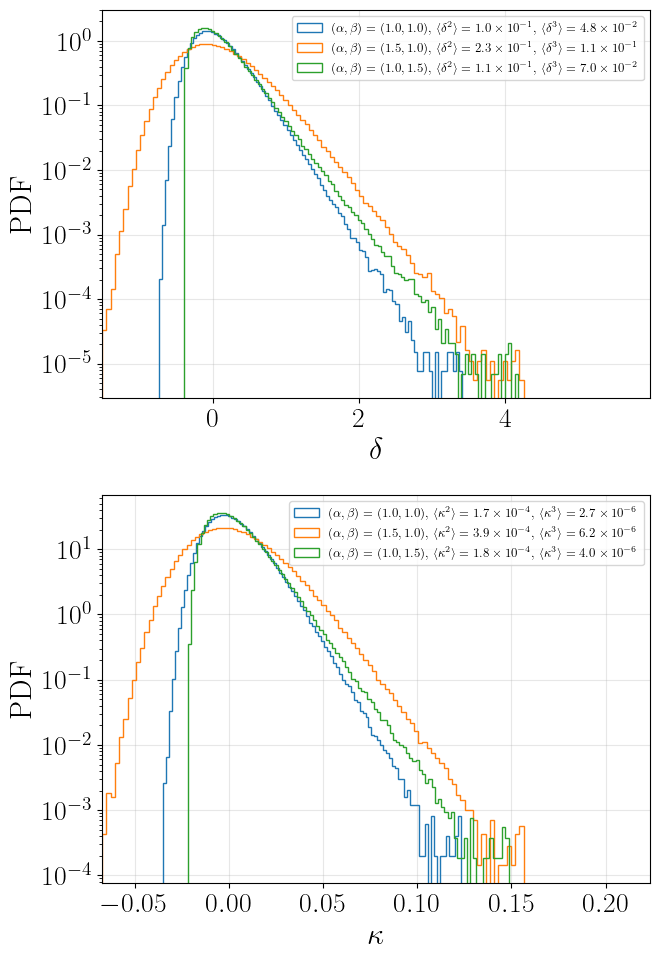

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=False)
x_all_delta = []
x_all_kappa = []

for label in param_grid:
    # --- Delta ---
    delta_map = delta_maps_all[label][0]
    x_all_delta.append(delta_map)
    m2_delta = np.mean(delta_map**2)
    m3_delta = np.mean(delta_map**3)

    # --- Kappa ---
    kappa_map = kappa_maps_all[label][-1]
    x_all_kappa.append(kappa_map)
    m2_kappa = np.mean(kappa_map**2)
    m3_kappa = np.mean(kappa_map**3)

    # --- Label handling ---
    if label == "fiducial":
        label_str = r"$(\alpha, \beta) = (1.0, 1.0),$"
    elif label == "alpha15":
        label_str = r"$(\alpha, \beta) = (1.5, 1.0),$"
    elif label == "beta15":
        label_str = r"$(\alpha, \beta) = (1.0, 1.5),$"
    else:
        label_str = fr"$(\alpha, \beta) = {label}$"

    # --- Delta label ---
    display_label_delta = (
        label_str
        + fr"  $\langle\delta^2\rangle={sci_notation(m2_delta)},$"
        + fr"  $\langle\delta^3\rangle={sci_notation(m3_delta)}$"
    )
    axs[0].hist(delta_map, bins=100, density=True, histtype='step', label=display_label_delta)

    # --- Kappa label ---
    display_label_kappa = (
        label_str
        + fr"  $\langle\kappa^2\rangle={sci_notation(m2_kappa)},$"
        + fr"  $\langle\kappa^3\rangle={sci_notation(m3_kappa)}$"
    )
    axs[1].hist(kappa_map, bins=100, density=True, histtype='step', label=display_label_kappa)

# --- Delta subplot settings ---
x_all_delta = np.concatenate(x_all_delta)
xmin_d, xmax_d = np.min(x_all_delta), np.max(x_all_delta)
pad_d = 0.3 * (xmax_d - xmin_d)
axs[0].set_xlim(xmin_d, xmax_d + pad_d)
axs[0].set_xlabel(r'$\delta$', fontsize=22)
axs[0].set_ylabel('PDF', fontsize=22)
axs[0].set_yscale('log')
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='upper right', fontsize=9)
#axs[0].set_title('1-point PDF of $\delta$ (lowest z)', fontsize=14)

# --- Kappa subplot settings ---
x_all_kappa = np.concatenate(x_all_kappa)
xmin_k, xmax_k = np.min(x_all_kappa), np.max(x_all_kappa)
pad_k = 0.3 * (xmax_k - xmin_k)
axs[1].set_xlim(xmin_k, xmax_k + pad_k)
axs[1].set_xlabel(r'$\kappa$', fontsize=22)
axs[1].set_ylabel('PDF', fontsize=22)
axs[1].set_yscale('log')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='upper right', fontsize=9)
#axs[1].set_title('1-point PDF of $\kappa$ (highest z)', fontsize=14)

plt.tight_layout()
plt.savefig('plots/combined_delta_kappa_fields.pdf')
plt.show()

# baryons field

In [68]:
import numpy as np
from bnt_smooth import ProcessMaps, NzEuclid

# --- Settings ---
nside = 512
l_max = 1500
nslices = 5
nbins = 5
z = np.linspace(0.01, 2.5, 500)
Nz = NzEuclid(nbins=nbins, z=z)
nz_list = Nz.get_nz()
n_eff_list = [30.0 / nbins] * nbins
sigma_eps_list = [0.26] * nbins

alpha, beta = 1.0, 1.0  # fiducial

kappa_maps_all_bf = {}
delta_maps_all_bf = {}

for b_feedback in [7.0, 10.0]:
    print(f"Generating maps for feedback={b_feedback}, alpha={alpha}, beta={beta}")
    sim = ProcessMaps(
        z_array=z,
        nz_list=nz_list,
        n_eff_list=n_eff_list,
        sigma_eps_list=sigma_eps_list,
        baryon_feedback=b_feedback,
        alpha=alpha,
        beta=beta,
        seed=42,
        l_max=l_max,
        nside=nside,
        nslices=nslices
    )

    sim.set_cosmo()

    gauss_fields = sim.generate_gauss_matter_fields_from_scratch()
    delta_maps = sim.make_skewed_delta_maps(gauss_fields)
    kappa_maps = sim.compute_kappa_maps(delta_maps)

    delta_maps_all_bf[b_feedback] = delta_maps
    kappa_maps_all_bf[b_feedback] = kappa_maps

Generating maps for feedback=7.0, alpha=1.0, beta=1.0
Generating maps for feedback=10.0, alpha=1.0, beta=1.0


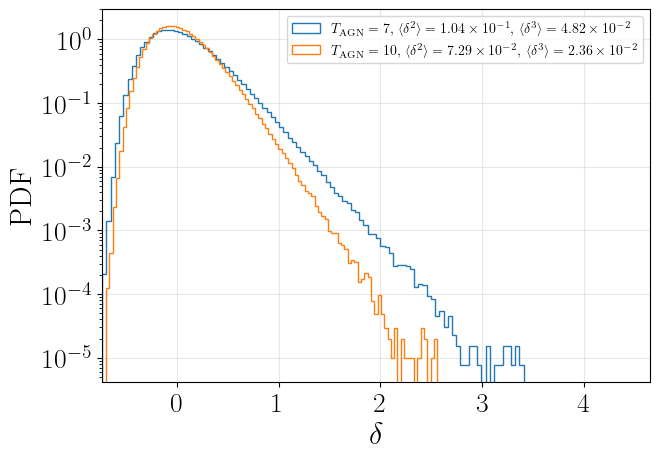

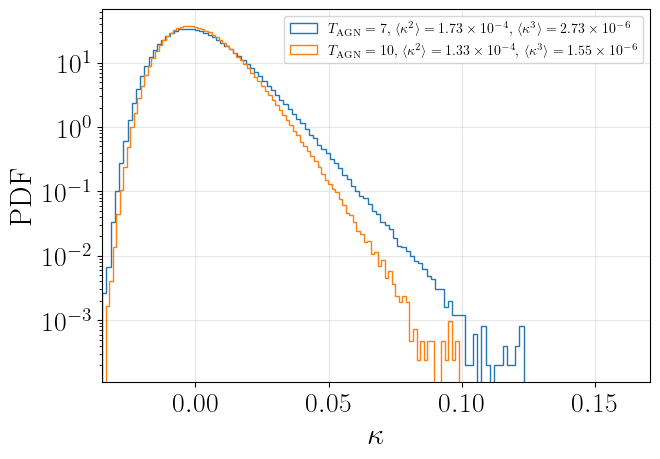

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def sci_notation(x):
    """Format a float in scientific notation with LaTeX-style 10^."""
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    return rf"{coeff:.2f} \times 10^{{{exponent}}}"

# --- Plot δ PDFs ---
fig, ax = plt.subplots(figsize=(7, 5))
x_all = []

for bf in [7.0, 10.0]:
    delta_map = delta_maps_all_bf[bf][0]  # lowest z bin
    x_all.append(delta_map)
    m2 = np.mean(delta_map**2)
    m3 = np.mean(delta_map**3)
    label = (
        rf"$T_{{\rm AGN}}={int(bf)}$"
        + rf", $\langle\delta^2\rangle={sci_notation(m2)},$"
        + rf" $\langle\delta^3\rangle={sci_notation(m3)}$"
    )
    ax.hist(delta_map, bins=100, density=True, histtype='step', label=label)

# Extend x-axis
x_all = np.concatenate(x_all)
xmin, xmax = np.min(x_all), np.max(x_all)
pad = 0.3 * (xmax - xmin)
ax.set_xlim(xmin, xmax + pad)

ax.set_xlabel(r'$\delta$', fontsize=22)
ax.set_ylabel('PDF', fontsize=22)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("plots/pdf_delta_feedback.pdf")
plt.show()

# --- Plot κ PDFs ---
fig, ax = plt.subplots(figsize=(7, 5))
x_all = []

for bf in [7.0, 10.0]:
    kappa_map = kappa_maps_all_bf[bf][-1]  # highest z bin
    x_all.append(kappa_map)
    m2 = np.mean(kappa_map**2)
    m3 = np.mean(kappa_map**3)
    label = (
        rf"$T_{{\rm AGN}}={int(bf)}$"
        + rf", $\langle\kappa^2\rangle={sci_notation(m2)},$"
        + rf" $\langle\kappa^3\rangle={sci_notation(m3)}$"
    )
    ax.hist(kappa_map, bins=100, density=True, histtype='step', label=label)

x_all = np.concatenate(x_all)
xmin, xmax = np.min(x_all), np.max(x_all)
pad = 0.3 * (xmax - xmin)
ax.set_xlim(xmin, xmax + pad)

ax.set_xlabel(r'$\kappa$', fontsize=22)
ax.set_ylabel('PDF', fontsize=22)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig("plots/pdf_kappa_feedback.pdf")
plt.show()